# Emotion Classification from Text Using Fine-Tuned DistilBERT


In [1]:
# Install datasets if needed
!pip install datasets -q

In [2]:
import numpy as np
import pandas as pd
import random
import re

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

MAX_LENGTH = 64
print("Max token length:", MAX_LENGTH)

Using device: cuda
Max token length: 64


In [3]:
from datasets import load_dataset
import pandas as pd

dataset = load_dataset("emotion")
df_full = pd.DataFrame(dataset["train"])

print("Full training set shape:", df_full.shape)
print("\nOriginal class distribution:")
print(df_full["label"].value_counts().sort_index())

df_full.head()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

split/train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

split/validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

split/test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Full training set shape: (16000, 2)

Original class distribution:
label
0    4666
1    5362
2    1304
3    2159
4    1937
5     572
Name: count, dtype: int64


,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [4]:
label_map = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise"
}

label_map

{0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

In [5]:
SUBSET_MAJOR = 1250  # for labels 0–4

dfs = []
for lbl in range(6):
    df_lbl = df_full[df_full["label"] == lbl]

    if lbl == 5:
        # keep all minority class examples (surprise)
        dfs.append(df_lbl)
    else:
        # sample fixed number from each majority class
        dfs.append(df_lbl.sample(n=SUBSET_MAJOR, random_state=42))

df_subset = pd.concat(dfs, ignore_index=True)

# Shuffle subset
df_subset = df_subset.sample(frac=1, random_state=42).reset_index(drop=True)

print("Subset shape:", df_subset.shape)
print("\nSubset class distribution:")
print(df_subset["label"].value_counts().sort_index())

Subset shape: (6822, 2)

Subset class distribution:
label
0    1250
1    1250
2    1250
3    1250
4    1250
5     572
Name: count, dtype: int64


In [6]:
train_df, temp_df = train_test_split(
    df_subset,
    test_size=0.2,
    stratify=df_subset["label"],
    random_state=SEED
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df["label"],
    random_state=SEED
)

print("Train size:", train_df.shape)
print("Validation size:", val_df.shape)
print("Test size:", test_df.shape)

print("\nTrain class distribution:")
print(train_df["label"].value_counts().sort_index())

print("\nValidation class distribution:")
print(val_df["label"].value_counts().sort_index())

print("\nTest class distribution:")
print(test_df["label"].value_counts().sort_index())

Train size: (5457, 2)
Validation size: (682, 2)
Test size: (683, 2)

Train class distribution:
label
0    1000
1    1000
2    1000
3    1000
4    1000
5     457
Name: count, dtype: int64

Validation class distribution:
label
0    125
1    125
2    125
3    125
4    125
5     57
Name: count, dtype: int64

Test class distribution:
label
0    125
1    125
2    125
3    125
4    125
5     58
Name: count, dtype: int64


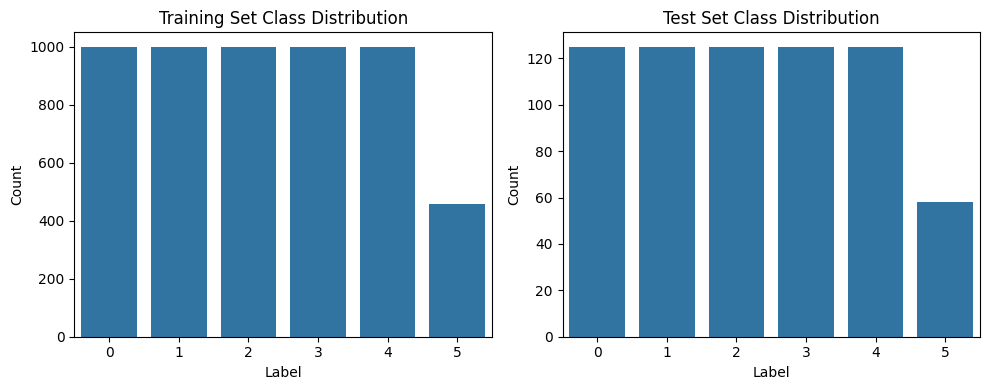

In [7]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
sns.countplot(x=train_df["label"])
plt.title("Training Set Class Distribution")
plt.xlabel("Label")
plt.ylabel("Count")

plt.subplot(1,2,2)
sns.countplot(x=test_df["label"])
plt.title("Test Set Class Distribution")
plt.xlabel("Label")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

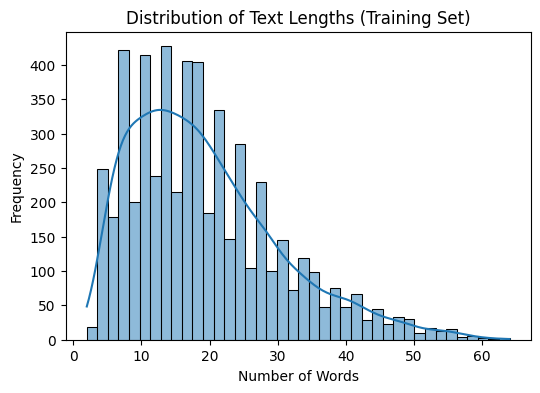

Average text length: 19.31482499541873
95th percentile text length: 41.0


In [8]:
train_df["text_length"] = train_df["text"].apply(lambda x: len(x.split()))

plt.figure(figsize=(6,4))
sns.histplot(train_df["text_length"], bins=40, kde=True)
plt.title("Distribution of Text Lengths (Training Set)")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

print("Average text length:", train_df["text_length"].mean())
print("95th percentile text length:", np.percentile(train_df["text_length"], 95))

In [9]:
train_df.sort_values("text_length", ascending=False).head(3)[["text", "text_length"]]

,text,text_length
3951,i lost my special mind but don t worry i m sti...,64
5970,i confused my feelings with the truth because ...,63
5440,i like to add a slice of cheese and some peppe...,62


In [10]:
X_train = train_df["text"]
y_train = train_df["label"]

X_val = val_df["text"]
y_val = val_df["label"]

X_test = test_df["text"]
y_test = test_df["label"]

In [11]:
tfidf = TfidfVectorizer(
    max_features=30000,
    ngram_range=(1,2),
    stop_words="english"
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf   = tfidf.transform(X_val)
X_test_tfidf  = tfidf.transform(X_test)

print("TF-IDF train shape:", X_train_tfidf.shape)

TF-IDF train shape: (5457, 30000)


In [12]:
baseline_model = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    solver="lbfgs",
    multi_class="multinomial"
)

baseline_model.fit(X_train_tfidf, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(class_weight='balanced', max_iter=2000,
                   multi_class='multinomial')

In [13]:
y_pred_baseline = baseline_model.predict(X_test_tfidf)

acc = accuracy_score(y_test, y_pred_baseline)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, y_pred_baseline, average="macro"
)

print("Baseline Model Performance (Test Set):")
print(f"Accuracy       : {acc:.4f}")
print(f"Macro Precision: {precision:.4f}")
print(f"Macro Recall   : {recall:.4f}")
print(f"Macro F1-score : {f1:.4f}")

Baseline Model Performance (Test Set):
Accuracy       : 0.8843
Macro Precision: 0.8790
Macro Recall   : 0.8916
Macro F1-score : 0.8833


In [14]:
tokenizer = DistilBertTokenizerFast.from_pretrained(
    "distilbert-base-uncased"
)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [15]:
def tokenize_texts(texts):
    return tokenizer(
        texts.tolist(),
        padding=True,
        truncation=True,
        max_length=MAX_LENGTH,
        return_tensors="pt"
    )

In [16]:
train_encodings = tokenize_texts(train_df["text"])
val_encodings   = tokenize_texts(val_df["text"])
test_encodings  = tokenize_texts(test_df["text"])

print("Train input_ids shape:", train_encodings["input_ids"].shape)
print("Train attention_mask shape:", train_encodings["attention_mask"].shape)

Train input_ids shape: torch.Size([5457, 64])
Train attention_mask shape: torch.Size([5457, 64])


In [17]:
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels.iloc[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [18]:
train_dataset = EmotionDataset(train_encodings, train_df["label"])
val_dataset   = EmotionDataset(val_encodings, val_df["label"])
test_dataset  = EmotionDataset(test_encodings, test_df["label"])

print("Train dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))
print("Test dataset size:", len(test_dataset))

Train dataset size: 5457
Validation dataset size: 682
Test dataset size: 683


In [19]:
BATCH_SIZE = 16

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Batches per epoch (train):", len(train_loader))

Batches per epoch (train): 342


In [20]:
import torch.nn as nn
import numpy as np

class_counts = np.bincount(train_df["label"])
print("Class counts:", class_counts)

# Inverse-frequency weighting
weights = 1.0 / class_counts
weights = weights / weights.sum()  # normalise

class_weights = torch.tensor(weights, dtype=torch.float).to(device)
print("Class weights:", class_weights)

loss_fn = nn.CrossEntropyLoss(weight=class_weights)

Class counts: [1000 1000 1000 1000 1000  457]
Class weights: tensor([0.1391, 0.1391, 0.1391, 0.1391, 0.1391, 0.3044], device='cuda:0')


In [21]:
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=6
).to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
from sklearn.metrics import accuracy_score

def evaluate(model, data_loader):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.logits, labels)
            total_loss += loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    acc = accuracy_score(all_labels, all_preds)
    return avg_loss, acc

In [24]:
from tqdm import tqdm

EPOCHS = 3
best_val_acc = 0
best_path = "distilbert_emotion_best.pt"

train_losses, val_losses, val_accs = [], [], []

for epoch in range(EPOCHS):
    model.train()
    total_train_loss = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs.logits, labels)

        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)
    val_loss, val_acc = evaluate(model, val_loader)

    train_losses.append(avg_train_loss)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {avg_train_loss:.4f}")
    print(f"Val Loss  : {val_loss:.4f}")
    print(f"Val Acc   : {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_path)
        print(f"Saved best checkpoint (Val Acc = {best_val_acc:.4f})")

print("\nBest Val Acc:", best_val_acc)

Epoch 1/3: 100%|██████████| 342/342 [00:30<00:00, 11.07it/s]



Epoch 1/3
Train Loss: 0.1823
Val Loss  : 0.3166
Val Acc   : 0.8988
Saved best checkpoint (Val Acc = 0.8988)


Epoch 2/3: 100%|██████████| 342/342 [00:31<00:00, 10.85it/s]



Epoch 2/3
Train Loss: 0.1324
Val Loss  : 0.2890
Val Acc   : 0.8974


Epoch 3/3: 100%|██████████| 342/342 [00:32<00:00, 10.63it/s]



Epoch 3/3
Train Loss: 0.1007
Val Loss  : 0.2701
Val Acc   : 0.9135
Saved best checkpoint (Val Acc = 0.9135)

Best Val Acc: 0.9134897360703812


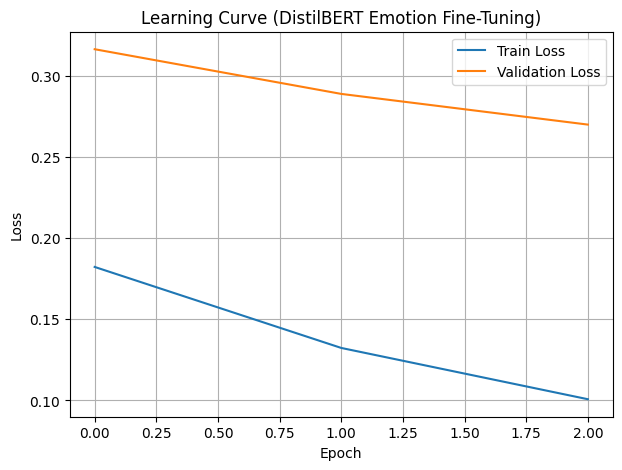

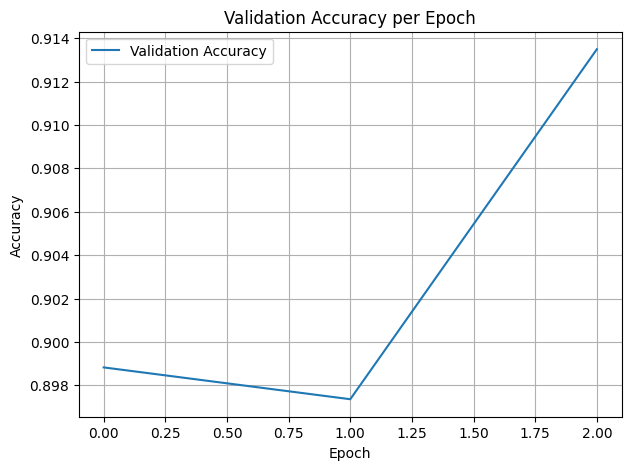

In [25]:
plt.figure(figsize=(7,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Learning Curve (DistilBERT Emotion Fine-Tuning)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(7,5))
plt.plot(val_accs, label="Validation Accuracy")
plt.title("Validation Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [26]:
best_model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=6
).to(device)

best_model.load_state_dict(torch.load(best_path, map_location=device))
best_model.eval()

print("Loaded best checkpoint for test evaluation.")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded best checkpoint for test evaluation.


In [27]:
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = best_model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Metrics
test_acc = accuracy_score(all_labels, all_preds)
prec, rec, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="macro")

print("DistilBERT Model Performance (Test Set):")
print(f"Accuracy       : {test_acc:.4f}")
print(f"Macro Precision: {prec:.4f}")
print(f"Macro Recall   : {rec:.4f}")
print(f"Macro F1-score : {f1:.4f}")

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=list(label_map.values())))

DistilBERT Model Performance (Test Set):
Accuracy       : 0.9356
Macro Precision: 0.9308
Macro Recall   : 0.9383
Macro F1-score : 0.9335

Classification Report:
              precision    recall  f1-score   support

     sadness       0.98      0.94      0.96       125
         joy       0.95      0.90      0.92       125
        love       0.90      0.98      0.94       125
       anger       0.97      0.94      0.95       125
        fear       0.93      0.90      0.91       125
    surprise       0.86      0.97      0.91        58

    accuracy                           0.94       683
   macro avg       0.93      0.94      0.93       683
weighted avg       0.94      0.94      0.94       683



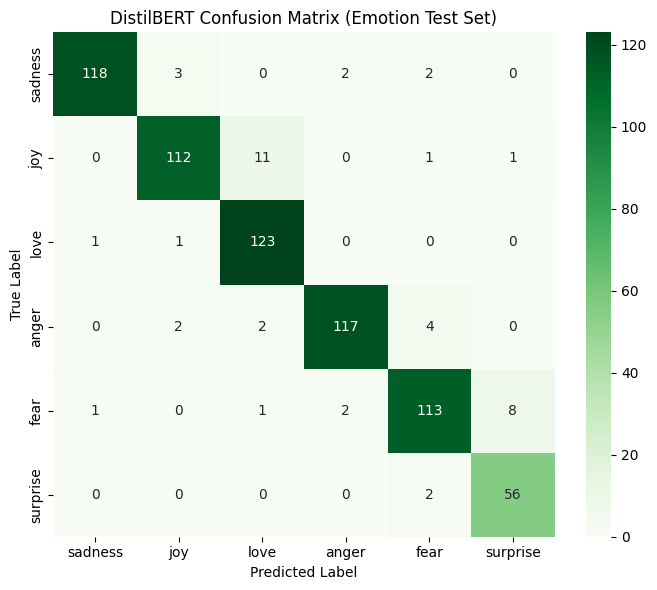

In [28]:
cm_bert = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(7,6))
sns.heatmap(
    cm_bert,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=list(label_map.values()),
    yticklabels=list(label_map.values())
)
plt.title("DistilBERT Confusion Matrix (Emotion Test Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [29]:
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# --- Baseline metrics (already computed) ---
baseline_acc = acc
baseline_prec, baseline_rec, baseline_f1, _ = precision_recall_fscore_support(
    y_test, y_pred_baseline, average="macro"
)

# --- DistilBERT metrics (from Section 9) ---
bert_acc = test_acc
bert_prec, bert_rec, bert_f1, _ = precision_recall_fscore_support(
    all_labels, all_preds, average="macro"
)

results_df = pd.DataFrame({
    "Model": ["TF-IDF + Logistic Regression", "DistilBERT (Fine-Tuned)"],
    "Accuracy": [baseline_acc, bert_acc],
    "Macro Precision": [baseline_prec, bert_prec],
    "Macro Recall": [baseline_rec, bert_rec],
    "Macro F1-score": [baseline_f1, bert_f1]
})

results_df

,Model,Accuracy,Macro Precision,Macro Recall,Macro F1-score
0,TF-IDF + Logistic Regression,0.884334,0.879032,0.891586,0.883343
1,DistilBERT (Fine-Tuned),0.935578,0.930834,0.938253,0.933463


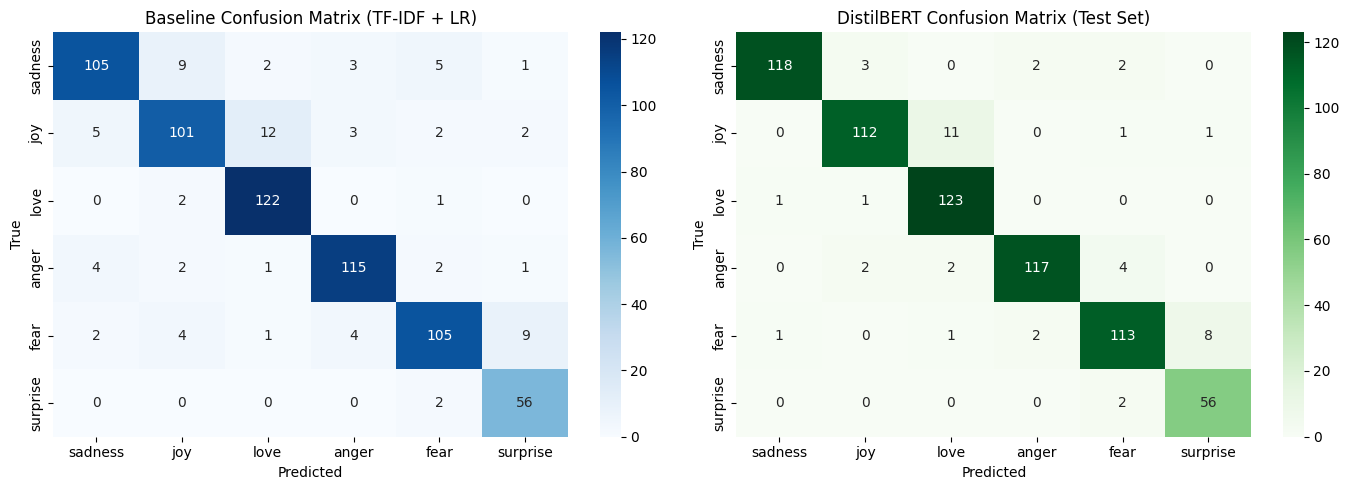

In [30]:
cm_baseline = confusion_matrix(y_test, y_pred_baseline)
cm_bert = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
sns.heatmap(
    cm_baseline, annot=True, fmt="d", cmap="Blues",
    xticklabels=list(label_map.values()),
    yticklabels=list(label_map.values())
)
plt.title("Baseline Confusion Matrix (TF-IDF + LR)")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.subplot(1,2,2)
sns.heatmap(
    cm_bert, annot=True, fmt="d", cmap="Greens",
    xticklabels=list(label_map.values()),
    yticklabels=list(label_map.values())
)
plt.title("DistilBERT Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.tight_layout()
plt.show()

In [31]:
import torch
import torch.nn.functional as F

emotion_labels = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise"
}

def predict_emotion(text, model, tokenizer, device):
    model.eval()

    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=64
    )

    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        probs = F.softmax(outputs.logits, dim=1).squeeze()

    pred_idx = torch.argmax(probs).item()
    pred_label = emotion_labels[pred_idx]
    confidence = probs[pred_idx].item()

    prob_dict = {
        emotion_labels[i]: round(probs[i].item(), 4)
        for i in range(len(emotion_labels))
    }

    return pred_label, confidence, prob_dict

In [32]:
sample_texts = [
    "I am so happy today, everything finally worked out perfectly!",
    "I feel completely heartbroken and empty inside.",
    "I was shaking with fear when I heard that noise.",
    "I can't believe how angry this situation has made me.",
    "I love spending quiet evenings with my family.",
    "Wow, I never expected that to happen!"
]

for text in sample_texts:
    label, conf, probs = predict_emotion(text, model, tokenizer, device)

    print("-" * 90)
    print(f"Text: {text}")
    print(f"Prediction: {label} (confidence: {conf:.4f})")
    print(f"Probabilities: {probs}")

------------------------------------------------------------------------------------------
Text: I am so happy today, everything finally worked out perfectly!
Prediction: joy (confidence: 0.9970)
Probabilities: {'sadness': 0.0005, 'joy': 0.997, 'love': 0.0014, 'anger': 0.0003, 'fear': 0.0002, 'surprise': 0.0005}
------------------------------------------------------------------------------------------
Text: I feel completely heartbroken and empty inside.
Prediction: sadness (confidence: 0.9962)
Probabilities: {'sadness': 0.9962, 'joy': 0.001, 'love': 0.0009, 'anger': 0.0007, 'fear': 0.0007, 'surprise': 0.0004}
------------------------------------------------------------------------------------------
Text: I was shaking with fear when I heard that noise.
Prediction: fear (confidence: 0.9958)
Probabilities: {'sadness': 0.0005, 'joy': 0.0009, 'love': 0.0002, 'anger': 0.0009, 'fear': 0.9958, 'surprise': 0.0017}
-------------------------------------------------------------------------------